In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
import pyarrow.parquet as pq
import pyarrow as pa

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
import os

/Users/Jason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Jason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Jason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Jason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [4]:
parent_directory = os.path.dirname(os.getcwd())
print(parent_directory)
# train_df_ = pd.read_csv(f'{parent_directory}/data/train.csv')
# test_df_ = pd.read_csv(f'{parent_directory}/data/test.csv')
# train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)
# train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] \
#     = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

/Users/Jason/Documents/Masters/data2040/bengali-char-recognition


In [2]:
# IMG_SIZE=64
IMG_X_SIZE = 87
IMG_Y_SIZE = 106
N_CHANNELS=1

In [4]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [6]:
# inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
inputs = Input(shape = (IMG_X_SIZE, IMG_Y_SIZE, 1))

# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_X_SIZE, IMG_Y_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax', name = "dense_root")(dense)
head_vowel = Dense(11, activation = 'softmax', name = "dense_vowel")(dense)
head_consonant = Dense(7, activation = 'softmax', name = "dense_consonant")(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
HEIGHT = 87
WIDTH = 106
batch_size = 256
epochs = 4

In [8]:
model.summary()
from keras.utils import plot_model
# plot_model(model, to_file=f'{parent_directory}/figures/model_architecture.png')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 87, 106, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 87, 106, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 87, 106, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 87, 106, 32)  9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

## For tomorrow, Tues Feb 25
Figure out how to integrate our homework version of the image data generator, and the format of the data that we have as pngs, into Shah's version of his model training.

In [5]:
# Preparing the preprocessed data for fitting in the model (takes about 15 mins to run)
# this is for GCP or local
proc_img_0 = pq.read_table(parent_directory+"/data/preprocessed/preprop_0.parquet").to_pandas()
proc_img_1 = pq.read_table(parent_directory+"/data/preprocessed/preprop_1.parquet").to_pandas()
proc_img_2 = pq.read_table(parent_directory+"/data/preprocessed/preprop_2.parquet").to_pandas()
proc_img_3 = pq.read_table(parent_directory+"/data/preprocessed/preprop_3.parquet").to_pandas()
train_images = pd.concat([proc_img_0, proc_img_1, proc_img_2, proc_img_3])
train_images.drop(columns=['image_id'],inplace=True)
del proc_img_0
del proc_img_1
del proc_img_2
del proc_img_3
# CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
train_images = train_images.values.reshape(-1, IMG_X_SIZE, IMG_Y_SIZE, N_CHANNELS)

In [7]:
train_labels = pd.read_csv(parent_directory+"/data/train.csv")
Y_train_root = pd.get_dummies(train_labels['grapheme_root']).values
Y_train_vowel = pd.get_dummies(train_labels['vowel_diacritic']).values
Y_train_consonant = pd.get_dummies(train_labels['consonant_diacritic']).values
del train_labels
print(f'Training images: {train_images.shape}')
print(f'Training labels root: {Y_train_root.shape}')
print(f'Training labels vowel: {Y_train_vowel.shape}')
print(f'Training labels consonants: {Y_train_consonant.shape}')
"""
Should see:
Training images: (200840, 87, 106, 1)
Training labels root: (200840, 168)
Training labels vowel: (200840, 11)
Training labels consonants: (200840, 7)
"""

Training images: (200840, 87, 106, 1)
Training labels root: (200840, 168)
Training labels vowel: (200840, 11)
Training labels consonants: (200840, 7)


'\nShould see:\nTraining images: (200840, 87, 106, 1)\nTraining labels root: (200840, 168)\nTraining labels vowel: (200840, 11)\nTraining labels consonants: (200840, 7)\n'

In [8]:
# below this should take around 5 minutes
x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant \
    = train_test_split(train_images, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.3, random_state=666)
del train_images
x_val, x_test, y_val_root, y_test_root, y_val_vowel, y_test_vowel, y_val_consonant, y_test_consonant \
    = train_test_split(x_test, y_test_root, y_test_vowel, y_test_consonant, test_size=0.33, random_state=666)
print(f'x_train size: {x_train.shape}')
print(f'x_val size: {x_val.shape}')
print(f'x_test size: {x_test.shape}')

x_train size: (140588, 87, 106, 1)
x_val size: (40368, 87, 106, 1)
x_test size: (19884, 87, 106, 1)


In [ ]:
# Preparing the data generator (should take two minutes)
# Data augmentation for creating more training data
datagen = MultiOutputDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# This will just calculate parameters required to augment the given data. This won't perform any augmentations
datagen.fit(x_train)

In [ ]:
# just for testing purposes
epochs = 1

In [ ]:
# Fit the model
history = model.fit_generator(
    datagen.flow(
        x_train, {'dense_root': y_train_root, 'dense_vowel': y_train_vowel, 'dense_consonant': y_train_consonant}, 
        batch_size=batch_size),
    epochs = epochs, validation_data = (x_val, [y_val_root, y_val_vowel, y_val_consonant]), 
    steps_per_epoch=x_train.shape[0] // batch_size, 
    callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant]
    )

histories.append(history)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 27/549 [>.............................] - ETA: 6:18:07 - loss: 9.7567 - dense_root_loss: 5.2857 - dense_vowel_loss: 2.6937 - dense_consonant_loss: 1.7772 - dense_root_accuracy: 0.0226 - dense_vowel_accuracy: 0.1834 - dense_consonant_accuracy: 0.5738

KeyboardInterrupt: 

In [ ]:
del x_train
del x_test
del y_train_root
del y_test_root
del y_train_vowel
del y_test_vowel
del y_train_consonant
del y_test_consonant
gc.collect()


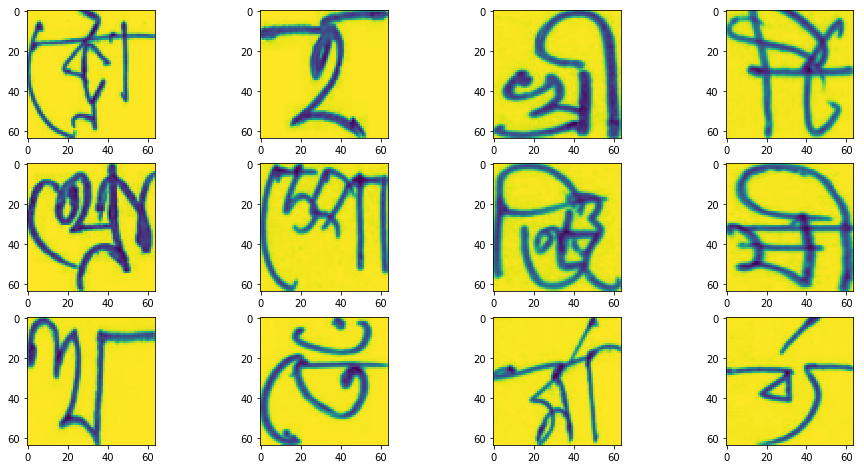


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 16/180 [=>............................] - ETA: 47:57 - loss: 10.1413 - dense_3_loss: 5.3491 - dense_4_loss: 2.7057 - dense_5_loss: 2.0864 - dense_3_accuracy: 0.0203 - dense_4_accuracy: 0.1755 - dense_5_accuracy: 0.5281

KeyboardInterrupt: 

In [ ]:
"""
OLD CODE - PLEASE REVIEW AT A LATER DATE
"""
histories = []
# this is to loop over the 4 different parquet files
# for i in range(4):
for i in range(1):
    train_df = pd.merge(pd.read_parquet(f'{parent_directory}/data/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
#     # Visualize few samples of current training dataset
#     fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
#     count=0
#     for row in ax:
#         for col in row:
#             col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
#             count += 1
#     plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
#     X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_X_SIZE, IMG_Y_SIZE, N_CHANNELS)
#     X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

### Things to try with our model
1. Learning Rate Scheduling
2. Early Stopping
3. Trying other Activation Functions
4. Dropout
5. MC Dropout for predictions
6. Try other augmentations
7. Try a different optimizer